      Child Disentanglement  Child Exists         Dataset         Model  \
1171               0.106912      0.198952      boxhead_07          vlae   
821                0.143564      0.204944      boxhead_07  vlae_larger2   
1409               0.048062      0.210515  boxheadsimple2  lvae_larger2   
1178               0.154254      0.228543      boxhead_07          vlae   
462                0.164677      0.253473      boxhead_07          lvae   

      Overall Disentanglement  Parent Disentanglement             beta  \
1171                 0.770057                0.231369  beta_5_annealed   
821                  0.770925                0.244390  beta_1_annealed   
1409                 0.509927                0.000000  beta_1_annealed   
1178                 0.588046                0.001761  beta_1_annealed   
462                  0.649412                0.000000  beta_1_annealed   

        gamma        random seed  
1171      NaN  [random_seed_100]  
821   gamma_5    [random_seed_1]  

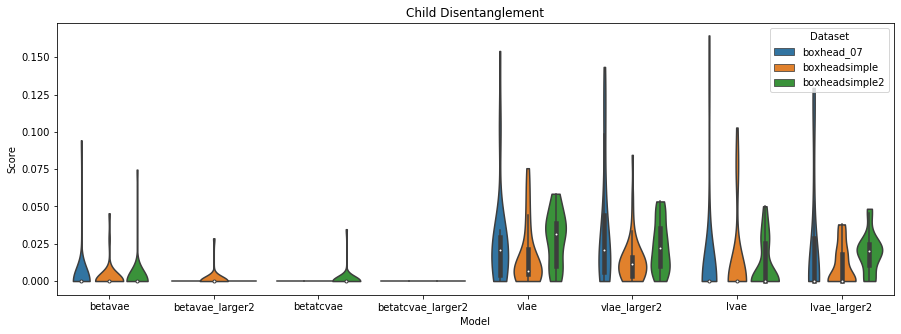

In [2]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from metrics import mutual_information, overall_disentanglement, parent_disentanglement, child_existence, child_disentanglement

def get_results():
    data = np.load("results.npz", allow_pickle=True)
    paths = data["path"]
    mi_scores = data["mi_score"]
    modelspecs = np.asarray([path.rstrip("/mutual_info_sample/final.npz").split(os.path.sep) for path in data["path"]])
    return mi_scores, modelspecs

def get_scores(mi_score):
    disentangled_non_hierarchy = overall_disentanglement(mi_score, independent_factors=[0,1,3,4,5])
    parent_score = parent_disentanglement(mi_score, 2, child_factors=[3,4,5,6])
    child_exists_score = child_existence(mi_score, parent_factor=2, child_factors=[3,4,5,6])
    child_dis_score=child_disentanglement(mi_score, parent_factor=2, child_factors=[3,4,5,6])
    return disentangled_non_hierarchy, parent_score, child_exists_score, child_dis_score


def format_data(modelspec, model_types, dataset_types):
    # get the model
    model = [i for i in model_types if i in modelspec]
    if not len(model): return None
    assert len(model) == 1, f"{len(model)}, {modelspec}"
    model = model[0]
    
    # get dataset
    dataset = [i for i in dataset_types if i in modelspec]
    if not len(dataset): return None
    assert len(dataset) == 1, f"{len(dataset)}, {modelspec}"
    dataset = dataset[0]
    
    # beta values
    beta = [i for i in modelspec if "beta_" in i][0]
    
    # gamma values
    gamma = [i for i in modelspec if "gamma_" in i]
    gamma = np.nan if not len(gamma) else gamma[0]
    
    # random seeds
    random_seed = [i for i in modelspec if "random_seed_" in i]
    
    # add to data
    return {"Model":model, "beta":beta, "gamma":gamma, "Dataset":dataset, "random seed": random_seed}

def get_data(mi_scores, modelspecs, dataset_types, model_types):
    data = pd.DataFrame()
    for modelnum in range(len(modelspecs)):
        modelspec, mi_score = modelspecs[modelnum], mi_scores[modelnum]
        disentangled_non_hierarchy, parent_score, child_exists_score, child_dis_score = get_scores(np.transpose(mi_score))
        data_record = format_data(modelspec=modelspec,
                                  model_types=model_types,
                                  dataset_types=dataset_types)
        if data is None: continue
        data_record.update({"Overall Disentanglement":disentangled_non_hierarchy, 
            "Parent Disentanglement":parent_score, 
            "Child Exists":child_exists_score, 
            "Child Disentanglement":child_dis_score})
        data = data.append(data_record, ignore_index=True)
    return data



def main():
    plt.rcParams["figure.figsize"]=15,5
    model_types = ["betavae","betatcvae","vlae","lvae"]+["betavae_larger2","betatcvae_larger2","vlae_larger2","lvae_larger2"]
    model_types = ["betavae","betavae_larger2","betatcvae","betatcvae_larger2","vlae","vlae_larger2","lvae","lvae_larger2"]
    dataset_types = ["boxhead_07", "boxheadsimple", "boxheadsimple2"]
    mi_scores, modelspecs = get_results()
    data = get_data(mi_scores=mi_scores,
                    modelspecs=modelspecs,
                    dataset_types=dataset_types,
                    model_types=model_types)
    
    cur_data = data
    cur_data = cur_data.loc[
        False
        |(data["beta"]=="beta_1_annealed")
        |(cur_data["beta"]=="beta_5_annealed")
        |(cur_data["beta"]=="beta_10_annealed")
        |(cur_data["beta"]=="beta_20_annealed")
    ]
    cur_data = cur_data.loc[
        False
        |(cur_data["Dataset"]=="boxhead_07")
        |(cur_data["Dataset"]=="boxheadsimple")
        |(cur_data["Dataset"]=="boxheadsimple2")
    ]
    score_types = [
        "Overall Disentanglement", 
        "Parent Disentanglement", 
        "Child Exists", 
        "Child Disentanglement"
    ]
    
    
    
    # get top n values given a column for each model.
    #new_data = []
    #for model in model_types:
    #        new_data.append(cur_data.loc[cur_data["Model"]==model].sort_values(by=['Child Disentanglement'])[-5:])
    #new_data = pd.concat(new_data)
    new_data = cur_data.sort_values(by=['Child Exists'])[-5:]
    print(new_data)


    #data if beta_vals is None else data.loc[data["beta"]==beta_vals]
    for score in score_types:
        plt.clf()
        plt.title(score)
        sns.violinplot(x='Model', y=score, hue="Dataset", order=model_types,
                       data=cur_data, 
                       #data=cur_data, 
                       #bw=.2, 
                       cut=0, 
                       #inner="stick"
                      )
        plt.ylabel("Score")
        plt.savefig(os.path.join("dev_paper", "images", score.replace(" ","_")+"_above_beta_1"+".png"))
        #plt.show()
    
    
    
main()

In [3]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
# from metrics import mutual_information, overall_disentanglement, parent_disentanglement, child_existence, child_disentanglement

data = np.load("results.npz", allow_pickle=True)
paths = data["path"]
mi_score = data["mi_score"]

plt.rcParams["figure.figsize"]=15,5
print(list(data.keys()))
modelspecs = np.asarray([path.rstrip("/mutual_info_sample/final.npz").split(os.path.sep) for path in data["path"]])

# get models aggregate
# model_types = ["betatcvae_larger2","betavae_larger2","vlae_larger2","lvae_larger2"]
# model_types = ["betatcvae","betavae","vlae","lvae"]
model_types = ["betavae","betatcvae","vlae","lvae"]+["betavae_larger2","betatcvae_larger2","vlae_larger2","lvae_larger2"]
dataset_types = [
    "boxhead_07", 
    "boxheadsimple", 
    "boxheadsimple2"
]

data = pd.DataFrame()
for modelnum, modelspec in enumerate(modelspecs):
    # get the scores
    disentangled_non_hierarchy, parent_score, child_exists_score, child_dis_score = get_scores(modelnum)
    
    # get the model
    model = [i for i in model_types if i in modelspec]
    if not len(model): continue
    assert len(model) == 1, f"{len(model)}, {modelspec}"
    model = model[0]
    
    # get dataset
    dataset = [i for i in dataset_types if i in modelspec]
    if not len(dataset): continue
    assert len(dataset) == 1, f"{len(dataset)}, {modelspec}"
    dataset = dataset[0]
    
    # beta values
    beta = [i for i in modelspec if "beta_" in i][0]
    
    # gamma values
    gamma = [i for i in modelspec if "gamma_" in i]
    gamma = np.nan if not len(gamma) else gamma[0]
    
    # random seeds
#     random_seed = [i for i in modelspec if "random_seed_" in i]
    
    # add to data
    score_mapping = {
        "Overall Disentanglement":disentangled_non_hierarchy, 
        "Parent Disentanglement":parent_score, 
        "Child Exists":child_exists_score, 
        "Child Disentanglement":child_dis_score
    }
    for score,value in score_mapping.items():
        data = data.append({
            "Model":model,
            "beta":beta,
            "gamma":gamma,
            "Dataset":dataset,
            "Score":score,
            "Value":value,
#             "random seed": random_seed
            },ignore_index=True)

#data = data.loc[data["beta"].str.contains("annealed")]

# cur_data = data.loc[
#     False
#     #|(data["beta"]=="beta_1")
#     |(data["beta"]=="beta_5")
#     |(data["beta"]=="beta_10")
#     |(data["beta"]=="beta_20")
# ]


        

['path', 'mi_score', 'disentangled_non_hierarchy', 'parent_score', 'child_exists_score', 'child_dis_score']


IndexError: too many indices for array